# **Sesión 1:** Calibración de Cámara 📷⚙️

## **Instalaciones**

In [1]:
!pip install numpy==1.26 opencv-python==4.8.0.76 imageio

## **Librerías**

In [2]:
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import imageio
import cv2
import copy
import glob
import os

## **Apartado A: Calibración de cámara** (derecha e izquierda)

En este apartado se realiza la calibración de dos cámaras de un sistema estereoscópico. Para ello se trabajará con las imágenes de las carpetas ``left`` y ``right``. En primer lugar se trabajará con la carpeta ``left``. Posteriormente, deberá repetir el proceso con las imágenes en la carpeta ``right``. Ambas carpetas contienen imágenes con las que se calibrarán las cámaras. En ellas aparece el patrón de calibración en diferentes posiciones y orientaciones. Estas imágenes serán los datos de entrada.

Los pasos que deberá seguir para calibrar una cámara son:

1. Defina y ejecute el método para cargar imágenes ``load_images()``.
2. Detecte las esquinas de los patrones usando ``cv2.findChessboardCorners()``. Refine las detecciones con ``cv2.cornerSubPix()``.
3. Compruebe que las detecciones son correctas dibujando los resultados con ``cv2.drawChessboardCorners()``.
4. Defina y ejecute el método ``get_chessboard_points(chessboard_shape, dx, dy)`` que proporcione las coordenadas 3D de las esquinas del patrón. El sistema de referencia utilizado deberá estar anclado al propio patrón.
5. Utilice ``cv2.calibrateCamera`` para obtener los parámetros de calibración para la cámara izquierda.

### **Tarea A.1:** Defina y ejecute el método para cargar imágenes ``load_images()``.

In [3]:
def load_images(filenames: List) -> List:
    return [imageio.imread(filename) for filename in filenames]

In [4]:
# TODO Build a list containing the paths of all images from the left camera
imgs_path = [f for f in glob.glob("../data/left/left*.jpg")]
imgs = load_images(imgs_path)
print(f'Loaded {len(imgs)} images')
# print(f'Image shape: {imgs}')

Loaded 19 images


/tmp/ipykernel_182370/283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


### **Tarea A.2:** Detecte las esquinas de los patrones usando ``cv2.findChessboardCorners()``. Refine las detecciones con ``cv2.cornerSubPix()``.

In [5]:
# TODO Find corners with cv2.findChessboardCorners()
corners = [cv2.findChessboardCorners(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (8, 6), None) for img in imgs]
print(f'Found corners in {len(corners)} images')

Found corners in 19 images


In [6]:
corners_copy = copy.deepcopy(corners)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)

# TODO To refine corner detections with cv2.cornerSubPix() you need to input grayscale images. Build a list containing grayscale images.
imgs_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in imgs]

corners_refined = [cv2.cornerSubPix(i, cor[1], (8, 6), (-1, -1), criteria) if cor[0] else [] for i, cor in zip(imgs_gray, corners_copy)]
print(f'Refined corners in {len(corners_refined)} images')

Refined corners in 19 images


### **Tarea A.3:** Compruebe que las detecciones son correctas dibujando los resultados con ``cv2.drawChessboardCorners()``

In [7]:
imgs_copy = copy.deepcopy(imgs)

In [8]:
# TODO Use cv2.drawChessboardCorners() to draw the cornes
for i, img in enumerate(imgs_copy):
    if corners[i][0]:
        cv2.drawChessboardCorners(img, (8, 6), corners_refined[i], True)
print('Corners drawn')

Corners drawn


In [9]:
# Crear Carpeta
if not os.path.exists("../Result"):
    os.makedirs("../Result")

In [10]:
# TODO Show images and save when needed

def show_image(img, title="Image", show=False):
    if show:
        cv2.imshow(title, img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    
def write_image(filename, img):
    cv2.imwrite(filename, img)

show_images = False
for i, img in enumerate(imgs_copy):
    show_image(img, f"Image {i}", show_images)
    write_image(f"../Result/left_corners_{i}.jpg", img)

### **Tarea A.4:** Defina y ejecute el método ``get_chessboard_points(chessboard_shape, dx, dy)``

In [32]:
# TODO Design the method. It should return a np.array with np.float32 elements
def get_chessboard_points(chessboard_shape, dx, dy):
    rows, columns = chessboard_shape
    
    objp = np.zeros((rows * columns, 3), np.float32)
    
    objp[:, :2] = np.mgrid[0:rows, 0:columns].T.reshape(-1, 2)
    
    objp[:, 0] *= dx
    objp[:, 1] *= dy 
    
    return objp

print('Chessboard points calculated')


Chessboard points calculated


In [12]:
# TODO You need the points for every image, not just one
chessboard_points = get_chessboard_points((8, 6), 30, 30)

objpoints = [chessboard_points for _ in range(len(imgs))]

### **Tarea A.5:** Utilice ``cv2.calibrateCamera()`` para obtener los parámetros de calibración para la cámara izquierda

In [13]:
# Filter data and get only those with adequate detections
valid_corners = [cor[1] for cor in corners if cor[0]]
# Convert list to numpy array
valid_corners = np.asarray(valid_corners, dtype=np.float32)

In [14]:
image_size = imgs[0].shape[1::-1]
valid_objpoints = []
valid_corners_filtered = []

for objp, corners in zip(objpoints, valid_corners):
    if corners is not None:
        valid_objpoints.append(objp)
        valid_corners_filtered.append(corners)
# TODO
rms, intrinsics, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    valid_objpoints,
    valid_corners_filtered,
    image_size,
    None,
    None
)

# Obtain extrinsics
extrinsics = list(map(lambda rvec, tvec: np.hstack((cv2.Rodrigues(rvec)[0], tvec)), rvecs, tvecs))


In [15]:
# Print outputs
print("Intrinsics:\n", intrinsics)
print("Distortion coefficients:\n", dist_coeffs)
print("Root mean squared reprojection error:\n", rms)

Intrinsics:
 [[419.17367963   0.         149.87203907]
 [  0.         420.67532299 128.88566155]
 [  0.           0.           1.        ]]
Distortion coefficients:
 [[ 2.54768626e-02 -3.34669238e+00  4.93017405e-03 -6.84826718e-03
   2.00281254e+01]]
Root mean squared reprojection error:
 0.153073113715625


### **Pregunta A.1:** Repita el proceso (carga de imágenes, detección y comprobación de esquinas, etc.) para la cámara derecha.

In [33]:
# TODO Homework

right_imgs_path = glob.glob('../data/right/right*.jpg')
right_imgs = load_images(right_imgs_path)

right_corners = [cv2.findChessboardCorners(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), (8, 6), None) for img in right_imgs]
right_corners_copy = copy.deepcopy(right_corners)

right_imgs_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in right_imgs]

right_corners_refined = [cv2.cornerSubPix(i, cor[1], (11, 11), (-1, -1), criteria) if cor[0] else [] for i, cor in zip(right_imgs_gray, right_corners_copy)]

right_imgs_copy = copy.deepcopy(right_imgs)
for i, img in enumerate(right_imgs_copy):
    if right_corners[i][0]:
        cv2.drawChessboardCorners(img, (8, 6), right_corners_refined[i], True)
    show_image(img, f"Right Image {i+1}")
    write_image(f"../Result/right_corners_{i+1}.jpg", img)
    # print(f"Right Image {i+1} saved")

valid_right_corners = []
valid_objpoints = []

for i, corner in enumerate(right_corners):
    if corner[0]: 
        valid_right_corners.append(corner[1])
        valid_objpoints.append(objpoints[i])

valid_right_corners = np.asarray(valid_right_corners, dtype=np.float32)


rms_right, intrinsics_right, dist_coeffs_right, rvecs_right, tvecs_right = cv2.calibrateCamera(
    valid_objpoints,
    valid_right_corners,
    right_imgs[0].shape[1::-1],
    None,
    None
)

print(f"Error RMS de la cámara derecha: {rms_right}")
print(f"Matriz intrínseca de la cámara derecha:\n{intrinsics_right}")
print(f"Coeficientes de distorsión de la cámara derecha:\n{dist_coeffs_right}")


Error RMS de la cámara derecha: 0.2058885062087141
Matriz intrínseca de la cámara derecha:
[[432.19183617   0.         146.77820872]
 [  0.         435.44775778 137.27781905]
 [  0.           0.           1.        ]]
Coeficientes de distorsión de la cámara derecha:
[[-0.1186237  -0.18601095  0.00625041 -0.00822418  1.08945435]]


/tmp/ipykernel_182370/283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


### **Pregunta A.2:** Diferencias entre cv2.findChessboardCorners() y cv2.cornerSubPix()

### **Diferencias entre `cv2.findChessboardCorners()` y `cv2.cornerSubPix()`**

- `cv2.findChessboardCorners()`: Esta función busca las esquinas del tablero de ajedrez en la imagen en escala de grises. Devuelve una lista de coordenadas aproximadas de las esquinas. Estas coordenadas son lo suficientemente precisas para encontrar la forma general del tablero, pero pueden no ser completamente exactas debido a distorsiones o ruidos en la imagen.

- `cv2.cornerSubPix()`: Esta función toma las coordenadas aproximadas devueltas por `cv2.findChessboardCorners()` y las refina a nivel de subpíxeles. Utiliza un criterio de terminación (como número máximo de iteraciones o error mínimo) para mejorar la precisión de las esquinas detectadas, proporcionando coordenadas mucho más precisas.

**Ejemplo visual:**
1. `cv2.findChessboardCorners()` encontrará las esquinas de manera general y rápida.
2. `cv2.cornerSubPix()` mejorará estas detecciones para que sean mucho más precisas, lo que es importante para la calibración de la cámara.


In [17]:
# TODO Homework

output_dir = "A2_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Charge image and convert to grayscale
img_path = glob.glob('../data/left/left*.jpg')[0]
img = cv2.imread(img_path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

chessboard_size = (8, 6)

ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

if ret:
    img_corners = img.copy()
    cv2.drawChessboardCorners(img_corners, chessboard_size, corners, ret)
    cv2.imwrite(f"{output_dir}/findChessboardCorners.jpg", img_corners)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.01)
    corners_refined = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

    img_corners_refined = img.copy()
    cv2.drawChessboardCorners(img_corners_refined, chessboard_size, corners_refined, ret)
    cv2.imwrite(f"{output_dir}/cornerSubPix.jpg", img_corners_refined)

    # (Descomentar)
    # cv2.imshow("Original Corners", img_corners)
    # cv2.imshow("Refined Corners", img_corners_refined)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    print(f"Imágenes guardadas en {output_dir}")
else:
    print("No se encontraron esquinas.")


Imágenes guardadas en A2_output


### **Pregunta A.3:** Número mínimo de imágenes necesarias para calibrar.

### **Número mínimo de imágenes necesarias para la calibración de la cámara**

Para calibrar una cámara, es necesario contar con suficientes imágenes de un tablero de ajedrez en diferentes posiciones y orientaciones. En general, se recomienda tener al menos 10 imágenes desde diferentes ángulos para lograr una calibración precisa. Sin embargo, el número mínimo de imágenes necesarias puede variar dependiendo de la complejidad de la distorsión de la lente y de la precisión deseada en la calibración.

#### Análisis basado en Pareto:
En la práctica, se puede realizar un análisis de Pareto para determinar cuántas imágenes adicionales reducen significativamente el error de calibración. El objetivo es minimizar el **error RMS** (Root Mean Square) que devuelve `cv2.calibrateCamera()` mientras se utilizan el menor número de imágenes posible. Si el error RMS no mejora significativamente con más imágenes, podemos decir que hemos alcanzado un número adecuado de imágenes para la calibración.

En resumen, **10 a 20 imágenes** es un rango razonable para calibrar la mayoría de las cámaras, pero la calidad y variabilidad de las imágenes son factores importantes.


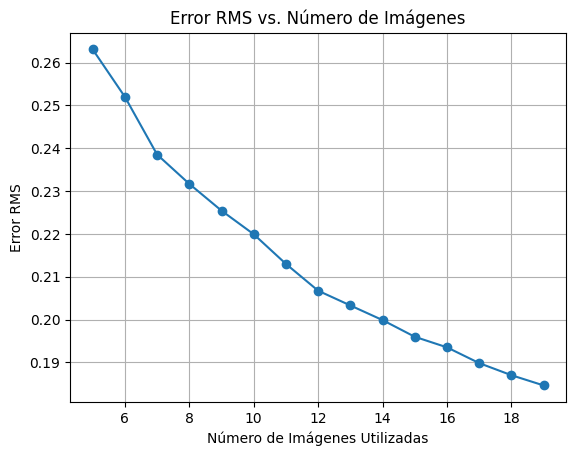

Gráfico guardado en A3_output


In [34]:
# TODO Homework

output_dir = "A3_output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# charge images and convert to grayscale
img_paths = glob.glob('../data/left/left*.jpg')
imgs = [cv2.imread(img) for img in img_paths]

chessboard_size = (8, 6)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objpoints = []
imgpoints = []

for img in imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

def calibrate_with_n_images(n):
    """
    Calibrar la cámara con 'n' imágenes y devolver el error RMS.
    """
    objpoints_subset = objpoints[:n]
    imgpoints_subset = imgpoints[:n]
    
    rms, _, _, _, _ = cv2.calibrateCamera(objpoints_subset, imgpoints_subset, gray.shape[::-1], None, None)
    
    return rms

rms_errors = []

for i in range(5, len(imgpoints) + 1):
    rms = calibrate_with_n_images(i)
    rms_errors.append(rms)

# Graficar los errores RMS
plt.plot(range(5, len(imgpoints) + 1), rms_errors, marker='o')
plt.xlabel("Número de Imágenes Utilizadas")
plt.ylabel("Error RMS")
plt.title("Error RMS vs. Número de Imágenes")
plt.grid()
plt.savefig(f"{output_dir}/rms_vs_images.png")
plt.show()

print(f"Gráfico guardado en {output_dir}")


## **Apartado B: Corrección de distorsión** (ojo de pez)

En este apartado se trabajará en la corrección de la distorsión debido a lentes de ojo de pez. Primero se calibrará una cámara con este tipo de lente, utilizando las imágenes de la carpeta ``fisheye``. Posteriormente se utilizarán estos parámetros de calibración para corregir la distorsión de una de las imágenes de calibración.

Los pasos que deberá seguir para calibrar una cámara con distorsión de ojo de pez son:

1. Reutilice el método ``load_images()`` para cargar las imágenes de la carpeta ``fisheye``.
2. Detecte las equinas procesando las imágenes con los métodos ``cv2.findChessboardCorners()`` y ``cv2.cornerSubPix()``.
3. Reutilice la función ``get_chessboard_points()`` para obtener las coordenadas del tablero.
4. Defina los argumentos para la función de calibración.
5. Calibre con ``cv2.fisheye.calibrate()``

### **Tarea B.1:** Reutilice el método ``load_images()`` para cargar las imágenes de la carpeta ``fisheye``

In [19]:


# TODO Build a list containing the paths of all images from the fisheye camera and load images
fisheye_imgs_path = glob.glob('../data/fisheye/*.jpg')
fisheye_imgs = load_images(fisheye_imgs_path)
print(f'Loaded {len(fisheye_imgs)} fisheye images')
print(fisheye_imgs_path)
# print(f'{fisheye_imgs}')

Loaded 10 fisheye images
['../data/fisheye/VMRImage8.jpg', '../data/fisheye/VMRImage1.jpg', '../data/fisheye/VMRImage9.jpg', '../data/fisheye/VMRImage5.jpg', '../data/fisheye/VMRImage3.jpg', '../data/fisheye/VMRImage0.jpg', '../data/fisheye/VMRImage4.jpg', '../data/fisheye/VMRImage2.jpg', '../data/fisheye/VMRImage6.jpg', '../data/fisheye/VMRImage7.jpg']


/tmp/ipykernel_182370/283608422.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  return [imageio.imread(filename) for filename in filenames]


### **Tarea B.2:** Detecte las equinas procesando las imágenes con los métodos ``cv2.findChessboardCorners()`` y ``cv2.cornerSubPix()``.

In [20]:
imgs_corners = []
# Parameters for cv2.cornerSubPix()
subpix_criteria = (cv2.TERM_CRITERIA_EPS+cv2.TERM_CRITERIA_MAX_ITER, 30, 0.1)
chessboard_size = (7, 6)
#TODO Complete the required parts of the loop
for img in fisheye_imgs:
    
    # TODO parse arguments to cv2.findChessboardCorners()
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray_img, chessboard_size, None)
    
    if ret:
        refined_corners = cv2.cornerSubPix(gray_img, corners, (3, 3), (-1, -1), subpix_criteria)
        
        imgs_corners.append(refined_corners)
    else:
        imgs_corners.append(None)
        
print(f'Número de imágenes procesadas: {len(imgs_corners)}')
print(f'Número de esquinas detectadas correctamente: {len([c for c in imgs_corners if c is not None])}')
# print(imgs_corners)

Número de imágenes procesadas: 10
Número de esquinas detectadas correctamente: 10


### **Tarea B.3:** Reutilice la función ``get_chessboard_points()`` para obtener las coordenadas del tablero

In [21]:
# TODO Define the chessboard dimensions and the lenght of the squares (in [mm])
chessboard_dims = (7, 6)
length = 30
# TODO You need the points for every image, not just one (consider a list comprehension)
fisheye_chessboard_points = [get_chessboard_points(chessboard_dims, length, length) for _ in range(len(fisheye_imgs))]
# print(f'{fisheye_chessboard_points}')

### **Tarea B.4:** Defina los argumentos para la calibración

In [22]:
# Parameters for cv2.fisheye.calibrate()
calibration_flags = cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC+cv2.fisheye.CALIB_FIX_SKEW
intrinsics = np.zeros((3, 3))
distortion = np.zeros((4, 1))
rotations = [np.zeros((1, 1, 3), dtype=np.float64) for _ in imgs_corners]
traslations = [np.zeros((1, 1, 3), dtype=np.float64) for _ in imgs_corners]


### **Tarea B.5:** Calibración

In [35]:
fisheye_chessboard_points = [np.array(points, dtype=np.float32).reshape(-1, 1, 3) for points in fisheye_chessboard_points]

imgs_corners = [np.array(corners, dtype=np.float32).reshape(-1, 1, 2) for corners in imgs_corners if corners is not None]

print(f"Tipo de datos de fisheye_chessboard_points después de la conversión: {type(fisheye_chessboard_points)}")
print(f"Forma de fisheye_chessboard_points después de la conversión: {np.array(fisheye_chessboard_points).shape}")
print(f"Tipo de datos de imgs_corners después de la conversión: {type(imgs_corners)}")
print(f"Forma de imgs_corners después de la conversión: {np.array(imgs_corners).shape}")

try:
    rms, intrinsics, distortion, rotations, traslations = cv2.fisheye.calibrate(
        fisheye_chessboard_points,
        imgs_corners,
        gray_img.shape[::-1],
        intrinsics,
        distortion,
        rotations,
        traslations,
        calibration_flags,
        (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)
    )

    # Mostrar los resultados de la calibración
    print(f"Error RMS: {rms}")
    print(f"Matriz intrínseca:\n{intrinsics}")
    print(f"Coeficientes de distorsión:\n{distortion}")
except cv2.error as e:
    print(f"Error en la calibración: {e}")


Tipo de datos de fisheye_chessboard_points después de la conversión: <class 'list'>
Forma de fisheye_chessboard_points después de la conversión: (10, 42, 1, 3)
Tipo de datos de imgs_corners después de la conversión: <class 'list'>
Forma de imgs_corners después de la conversión: (10, 42, 1, 2)
Error en la calibración: OpenCV(4.8.0) /io/opencv/modules/calib3d/src/fisheye.cpp:757: error: (-215:Assertion failed) rvecs.empty() || (rvecs.channels() == 3) in function 'calibrate'



In [25]:
# Show intrinsic matrix and distortion coefficients values
print(intrinsics)
print(distortion)

[[188.86914026   0.         503.92900347]
 [  0.         185.32638678 373.58044468]
 [  0.           0.           1.        ]]
[[ 0.07734388]
 [ 0.01482361]
 [ 0.02351869]
 [-0.02757565]]


### **Pregunta B.1:** Corrija la distorsión de las 2 primeras imágenes de la carpeta ``fisheye``

In [26]:
# TODO Search in the documentation to define 'dim'
dim = fisheye_imgs[0].shape[1::-1]
map1, map2 = cv2.fisheye.initUndistortRectifyMap(intrinsics, distortion, np.eye(3), intrinsics, dim, cv2.CV_16SC2)

In [36]:
# TODO Homework: correct distortion using cv2.remap()

undistorted_imgs = []

num_imgs_to_correct = 2

for i, img in enumerate(fisheye_imgs[:num_imgs_to_correct]):
    undistorted_img = cv2.remap(img, map1, map2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
    
    undistorted_imgs.append(undistorted_img)
    
    cv2.imwrite(f'undistorted_fisheye_image_{i+1}.jpg', undistorted_img)
    
    # (Descomentar para mostrar)
    # cv2.imshow(f'Undistorted Image {i+1}', undistorted_img)
    # cv2.waitKey(2000)  # Mostrar la imagen durante 500ms (ajustable)

cv2.destroyAllWindows()